# Educational notebook based on Sargolini 2006

This tutorial demonstrates how to access the dataset published in [Sargolini et al. (Science, 2006)](https://doi.org/10.1126/science.1125572) using `dandi`.

The [dataset](https://dandiarchive.org/dandiset/000582/draft) contains spike times for recorded grid cells from the medial entorhinal cortex (MEC) in rats that explored two-dimensional environments. The behavioral data includes position from the tracking LED(s).


#### Contents:
* [Access data and metadata](#access-nwb)
* [View NWB files with NWBWidgets](#view-nwb)
...

In [1]:
from dandi.dandiapi import DandiAPIClient

dandiset_id = "000582"
file_path = "sub-10073/sub-10073_ses-17010302_behavior+ecephys.nwb" # file size ~15.6MB

# Get the location of the file on DANDI
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(file_path)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

A newer version (0.55.1) of dandi/dandi-cli is available. You are using 0.50.0


In [3]:
from fsspec.implementations.cached import CachingFileSystem
from fsspec import filesystem
from h5py import File
from pynwb import NWBHDF5IO


# Create a virtual filesystem based on the http protocol and use caching to save accessed data to RAM.
fs = filesystem("http")
file_system = fs.open(s3_url, "rb")
file = File(file_system, mode="r")
# Open the file with NWBHDF5IO
io = NWBHDF5IO(file=file, load_namespaces=True)

nwbfile = io.read()

/Users/weian/opt/anaconda3/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/weian/opt/anaconda3/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [15]:
nwbfile.session_description

/Users/weian/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'This session includes spike and position times for recorded cells from a Long Evans rat that was running in a 1 x 1 meter enclosure. The cells were recorded in the dorsocaudal 25% portion of the medial entorhinal cortex (MEC).Position is given for two LEDs to enable calculation of head direction.'

In [8]:
nwbfile.processing["behavior"].data_interfaces["Position"].spatial_series["SpatialSeriesLED1"]

/Users/weian/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SpatialSeriesLED1 pynwb.behavior.SpatialSeries at 0x140278199954448
Fields:
  comments: no comments
  conversion: 0.01
  data: <HDF5 dataset "data": shape (30000, 2), type "<f8">
  description: Position (x, y) for the first tracking LED.
  interval: 1
  offset: 0.0
  reference_frame: (0,0) is not known.
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (30000,), type "<f8">
  timestamps_unit: seconds
  unit: meters

In [10]:
import pynapple as nap

spatial_series = nwbfile.processing["behavior"].data_interfaces["Position"].spatial_series["SpatialSeriesLED1"]
timestamps = spatial_series.timestamps[:]
tf = nap.TsdFrame(d=spatial_series.data[:], t=spatial_series.timestamps[:], columns=["x","y"])
tf

/Users/weian/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: Shape of passed values is (2, 5), indices imply (5, 2)

                 x          y
Time (s)                     
0.00     -0.442795  17.103931
0.02     -0.442795  17.103931
0.04      1.267783  16.859563
0.06      1.267783  16.859563
0.08     -0.198426  17.103931
...            ...        ...
599.90    2.245255   4.885523
599.92    2.245255   4.885523
599.94    2.000887   6.840468
599.96    2.000887   6.840468
599.98    0.779046   4.641155

[30000 rows x 2 columns]

In [3]:
spikes = {i: nap.Ts(x) for i, x in enumerate(nwbfile.units["spike_times"])}


In [4]:
tsg = nap.TsGroup(spikes)
tsg

  Index    rate
-------  ------
      0    2.93
      1    1.5
      2    2.58
      3    1.13
      4    1.29
      5    1.36
      6    2.89
      7    1.47

In [5]:
tc, xy = nap.compute_2d_tuning_curves(tsg, tf, 40)

/Users/weian/opt/anaconda3/envs/sargolini-to-nwb/lib/python3.10/site-packages/pynapple/process/tuning_curves.py:202: RuntimeWarning: invalid value encountered in divide
  count = count / occupancy


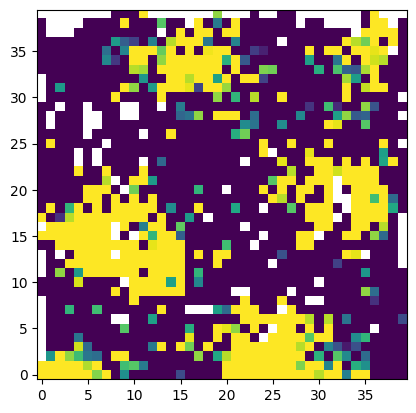

In [6]:
import matplotlib.pyplot as plt

plt.imshow(tc[0], origin="lower", vmax=4)

In [20]:
import statsmodels.api as sm

acorr_x = sm.tsa.acf(tc[0][0, :], nlags = 10)
acorr_y = sm.tsa.acf(tc[0][1, :], nlags = 10)

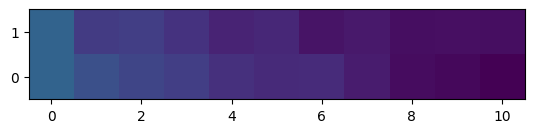

In [22]:
import scipy 


scipy.signal.correlate2d(tc[0], )

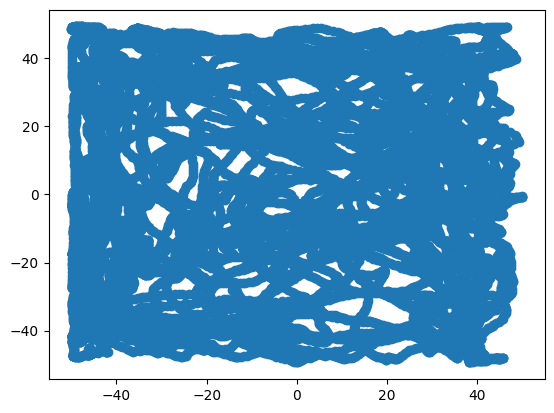

In [25]:

plt.scatter(nwbfile.processing["behavior"]["Position"]["SpatialSeriesLED1"].data[:, 0], nwbfile.processing["behavior"]["Position"]["SpatialSeriesLED1"].data[:, 1])